### Download the captcha images

In [1]:
import requests
import time
import os

##### image 다운로드

In [ ]:
url = "https://www.e-zpassny.com/vector/jcaptcha.do"
total = 0

for i in range(0, 500):
    try:
        # try to grab a new captcha image
        r = requests.get(url, timeout=60)

        # save the image to disk
        p = os.path.sep.join(['captchas', "{}.jpg".format(str(total).zfill(5))])
        f = open(p, "wb")
        f.write(r.content)
        f.close()

        # update the counter
        if total % 100 == 0:
            print("[INFO] downloaded: {}".format(p))
        total += 1
    
    except:
        print("[INFO] error downloading image...")
              
    # insert a small sleep to be courteous to the server
    time.sleep(0.1)        

##### annotation 주석달기 - 각 이미지의 숫자를 분리해서 각 폴더로 저장하기

In [2]:
from imutils import paths
import imutils
import cv2
import os

import matplotlib.pyplot as plt
%matplotlib inline

Processing image 1/505


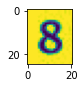

 8


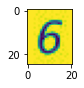

 6


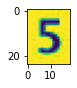

 5


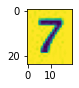

 7


Processing image 2/505


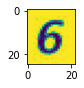

 6


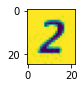

 2


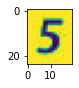

 5


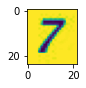

 7


In [167]:
imagePaths = list(paths.list_images('captchas'))
counts = {}

for (i, imagePath) in enumerate(imagePaths[0:2]):
#     if i % 100 == 0:
    print("Processing image {}/{}".format(i + 1, len(imagePaths)))
    
    try:
        # load the image and convert it to grayscale, then pad the image to ensure digits caught only
        # the border of the image are retained
        image = cv2.imread(imagePath)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        gray = cv2.copyMakeBorder(gray, 8, 8, 8, 8, cv2.BORDER_REPLICATE)
        
        # threshold the image to reveal the digits
        thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        
        # find contours in the image, keeping only the four largest ones
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#         cnts = cnts[0] if imutils.is_cv2() else cnts[1]
        cnts = cnts[0]
        cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:4]
        
        # loop over the contours
        for c in cnts:
            # compute the bounding box for the contour then extract the digit
            (x, y, w, h) = cv2.boundingRect(c)
            roi = gray[y - 5:y + h + 5, x -5:x + w + 5]

            # display the character, making it larger enough for us to see, then wait for a keypress
            #cv2.imshow("ROI", imutils.resize(roi, width=28))
            #key = cv2.waitKey(0)
            plt.subplots(figsize=(1,1))
            plt.imshow(roi)
            plt.show()
            key = input()

            # grab the key that was pressed and construct the path the output directory
            dirPath = os.path.sep.join(['no_labels', key])

            # if the output directory does not exist, create it
            if not os.path.exists(dirPath):
                os.makedirs(dirPath)

            # write the labeled character to file
            count = counts.get(key, 1)
            p = os.path.sep.join([dirPath, "{}.png".format(
                str(count).zfill(6))])
            cv2.imwrite(p, roi)

            # increment the count for the current key
            counts[key] = count + 1
            
    # we are trying to control-c out of the script, so break from the loop (you still need to press a key for the active window to trigger this)
    except KeyboardInterrupt:
        print("[INFO] manually leaving script")
        break

    # an unknown error has occurred for this particular image
    except:
        print("[INFO] skipping image...")            

### Preprocessing the digits

In [3]:
def digit_preprocess(image, width, height):
    (h, w) = image.shape[:2]
    
    if w > h:
        image = imutils.resize(image, width=width)
    
    else:
        image = imutils.resize(image, height=height)
        
    # determine the padding values for the width and height to obtain the target dimensions
    padW = int((width - image.shape[1]) / 2.0)
    padH = int((height - image.shape[0]) / 2.0)
    
    # pad the image then apply one more resizing to handle any rounding issues
    image = cv2.copyMakeBorder(image, padH, padH, padW, padW, cv2.BORDER_REPLICATE)
    image = cv2.resize(image, (width, height))
    
    return image

### Training the Captcha Breaker

In [4]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.optimizers import SGD
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import img_to_array

In [6]:
# import the necessary packages

def LeNet(width, height, depth, classes):
        # initialize the model
        model = Sequential()
        inputShape = (height, width, depth)

        # if we are using "channels first", update the input shape
        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)

        # first set of CONV => RELU => POOL layers
        model.add(Conv2D(20, (5, 5), padding="same", input_shape=inputShape))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

        # second set of CONV => RELU => POOL layers
        model.add(Conv2D(50, (5, 5), padding="same"))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

        # first (and only) set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(500))
        model.add(Activation("relu"))

        # softmax classifier
        model.add(Dense(classes))
        model.add(Activation("softmax"))
    
        # return the constructed network architecture
        return model

In [7]:
data = []
labels = []

for imagePath in list(paths.list_images("no_labels")):
    # load the image, pre-prcoess it and store it in the data list
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = digit_preprocess(image, 28, 28)
    image = img_to_array(image)
    data.append(image)
    
    label = imagePath.split(os.path.sep)[-2]
    labels.append(label)

In [8]:
data = np.array(data, dtype="float")/255.0
labels = np.array(labels)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.25, random_state=42)

In [10]:
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)

In [11]:
model = LeNet(width=28, height=28, depth=1, classes=9)
opt = SGD(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [12]:
H = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=15, verbose=1)

Epoch 1/15
48/48 [==============================] - 1s 25ms/step - loss: 2.1834 - accuracy: 0.1838 - val_loss: 2.1316 - val_accuracy: 0.2326
Epoch 2/15
48/48 [==============================] - 1s 12ms/step - loss: 2.1003 - accuracy: 0.3281 - val_loss: 2.0496 - val_accuracy: 0.4453
Epoch 3/15
48/48 [==============================] - 1s 11ms/step - loss: 1.9759 - accuracy: 0.6057 - val_loss: 1.8520 - val_accuracy: 0.3121
Epoch 4/15
48/48 [==============================] - 1s 12ms/step - loss: 1.7081 - accuracy: 0.7149 - val_loss: 1.4082 - val_accuracy: 0.5885
Epoch 5/15
48/48 [==============================] - 1s 11ms/step - loss: 1.0604 - accuracy: 0.9032 - val_loss: 0.9709 - val_accuracy: 0.4732
Epoch 6/15
48/48 [==============================] - 1s 11ms/step - loss: 0.4616 - accuracy: 0.9472 - val_loss: 0.2199 - val_accuracy: 1.0000
Epoch 7/15
48/48 [==============================] - 1s 11ms/step - loss: 0.1444 - accuracy: 0.9996 - val_loss: 0.1006 - val_accuracy: 1.0000
Epoch 8/15
48

In [18]:
model_name = "captchas_model.hdf5"

In [19]:
predictions = model.predict(X_test, batch_size=32)
print(classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1), target_names = lb.classes_))
model.save(model_name)

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        51
           2       1.00      1.00      1.00        75
           3       1.00      1.00      1.00        57
           4       1.00      1.00      1.00        43
           5       1.00      1.00      1.00        55
           6       1.00      1.00      1.00        63
           7       1.00      1.00      1.00        64
           8       1.00      1.00      1.00        49
           9       1.00      1.00      1.00        46

    accuracy                           1.00       503
   macro avg       1.00      1.00      1.00       503
weighted avg       1.00      1.00      1.00       503



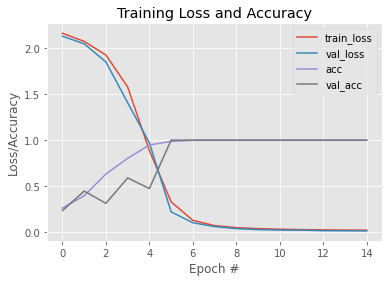

In [20]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 15), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 15), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 15), H.history["accuracy"], label="acc")
plt.plot(np.arange(0, 15), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

### Testing the Captcha Breaker

In [21]:
from tensorflow.keras.models import load_model
from imutils import contours
from imutils import paths
import imutils
import cv2

[INFO] captcha: 6785


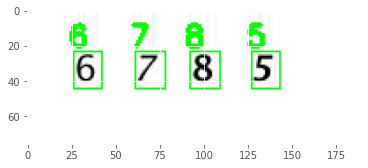

[INFO] captcha: 5362


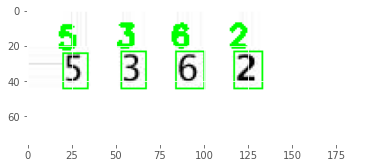

[INFO] captcha: 8459


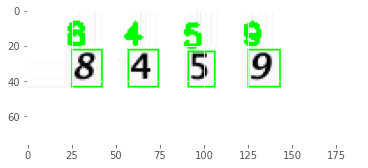

[INFO] captcha: 9343


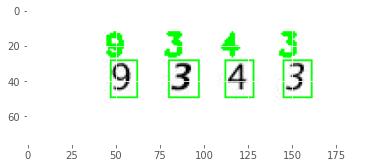

[INFO] captcha: 5677


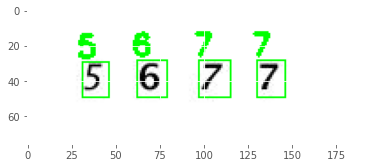

[INFO] captcha: 7788


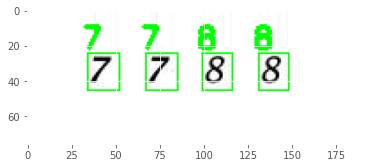

[INFO] captcha: 7533


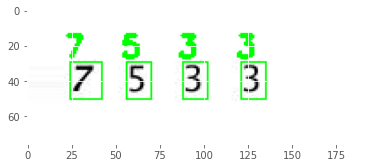

[INFO] captcha: 8456


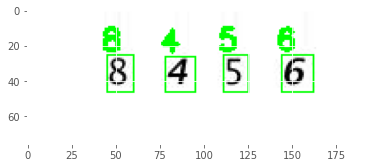

[INFO] captcha: 7523


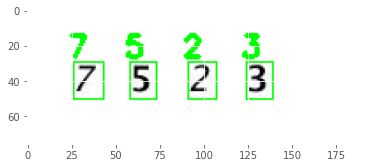

[INFO] captcha: 3633


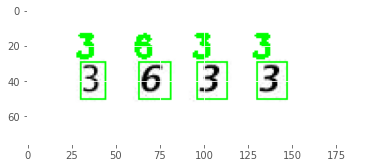

In [27]:
model = load_model(model_name)

imagePaths = list(paths.list_images("captchas"))
imagePaths = np.random.choice(imagePaths, size=(10,), replace=False)

for imagePath in imagePaths:
    # load the image and convert it to grayscale, then pad the image
    # to ensure digits caught only the border of the image are
    # retained    
    image = cv2.imread(imagePath)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.copyMakeBorder(gray, 20, 20, 20, 20, cv2.BORDER_REPLICATE)
    
    # threshold the image to reveal the digits
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2. THRESH_OTSU)[1]
    
    # find contours in the image, keeping only the four largest ones, # then sort them from left-to-right
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#     cnts = cnts[0] if imutils.is_cv2() else cnts[1]
    cnts = cnts[0]
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:4]
    cnts = contours.sort_contours(cnts)[0]
    
    # initialize the output image as a "grayscale" image with 3
    # channels along with the output predictions
    output = cv2.merge([gray] * 3)
    predictions = []

    # loop over the contours
    for c in cnts:
        # compute the bounding box for the contour then extract the digit
        (x, y, w, h) = cv2.boundingRect(c)
        roi = gray[y - 5:y + h + 5, x - 5:x + w + 5]

        # pre-process the ROI and classify it then classify it
        roi = digit_preprocess(roi, 28, 28)
        roi = np.expand_dims(img_to_array(roi), axis=0)
        pred = model.predict(roi).argmax(axis=1)[0] + 1
        predictions.append(str(pred))

        # draw the prediction on the output image
        cv2.rectangle(output, (x - 2, y - 2), (x + w + 4, y + h + 4), (0, 255, 0), 1)
        cv2.putText(output, str(pred), (x - 5, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.55, (0, 255, 0), 2)

    # show the output image
    print("[INFO] captcha: {}".format("".join(predictions)))
    plt.imshow(output)
    plt.show()
#     cv2.imshow("Output", output)
#     cv2.waitKey()   
    